# **Testing of the DINN model**

This test is based on the paper :

```
@inproceedings{yu2019deep,
  title={Deep iterative down-up CNN for image denoising},
  author={Yu, Songhyun and Park, Bumjun and Jeong, Jechang},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops},
  year={2019}
```
And, the implementation is majorly based on: [https://github.com/SonghyunYu/DIDN/blob/master/color_eval.py](https://github.com/SonghyunYu/DIDN/blob/master/color_eval.py)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Patch Generator

The function ```gen_patch(img_list, noise_level)``` takes the list of all testing images with specific noise level to form set of noisy and clean patches. Moreover, it also returns the patch position in order to retrieve the patches in original image



In [ ]:
import cv2
import numpy as np
import glob

def gen_patch(img_list, noise_level):
    Patch = []
    Noisy_Patch = []
    Patch_position = []
    patch_size = 64
    stride = 64
    n = len(img_list)
    print(n)
    for i in range(n):
        img = cv2.imread(img_list[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for p in range(0, img.shape[0] - patch_size+1, stride):
            for q in range(0, img.shape[1] - patch_size+1, stride):
                height_slice = slice(p, p+patch_size)
                width_slice = slice(q, q+patch_size)
                pos = (i, p, q)
                Patch_position.append(pos)
                patch = img[height_slice, width_slice, :]
                AWG_noise = np.random.normal(0.0, noise_level/255.0, patch.shape)
                noisyImg_patch = patch/255.0 + AWG_noise
                noisyImg_patch.astype(np.float32)
                Target_patch = patch/255.0
                Target_patch.astype(np.float32)
                Patch.append(Target_patch) 
                Noisy_Patch.append(noisyImg_patch)         
                
    return np.array(Patch), np.array(Noisy_Patch), np.array(Patch_position)

## Noisy Patches

Forming noisy patches from set of patches in **CBSD68 test dataset**.

In [ ]:
test_path = '/content/drive/My Drive/CBSD68'
test_file_list = glob.glob(test_path+'/*.jpg') 
Noise_Level = [10, 20, 30, 40, 50]  # Noise level for testing on difeerent values
Patch, Noisy_patch10, Patch_position = gen_patch(test_file_list, Noise_Level[0])
_, Noisy_patch20, _ = gen_patch(test_file_list, Noise_Level[1])
_, Noisy_patch30, _ = gen_patch(test_file_list, Noise_Level[2])
_, Noisy_patch40, _ = gen_patch(test_file_list, Noise_Level[3])
_, Noisy_patch50, _ = gen_patch(test_file_list, Noise_Level[4])

68
68
68
68
68


## Testing Model

In [ ]:
from keras.models import load_model
import time, math
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim

In [ ]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1)

Here, we are retrieving the trained model for denoising of natural images

In [ ]:
path = '/content/drive/My Drive/BSR_bsds500/log/exp-2'
# Name experiment
experiment_name = "exp-2"
model = load_model('{}/{}.h5'.format(path, experiment_name), custom_objects={'PSNR': PSNR})

The function ```predict_image(clean_patch, Noisy_patch, model)``` takes the patches of CBSD68 test set, corresponding noisy patch and trained model. It prints the time taken for one patch prediction and gives predicted output image, corresponding PSNR(dB) & SSIM.



In [ ]:
def predict_image(clean_patch, Noisy_patch, model):
  psnr = []
  predimg = []
  ssim = []
  for i in range(Noisy_patch.shape[0]):
    noise_patch = np.expand_dims(Noisy_patch[i], axis=0)
    start_time = time.time()
    pred = model.predict(noise_patch)
    end_time = time.time()
    
    pred_image = pred.squeeze()
    pred_image.astype(np.float32)
    predimg.append(pred_image)
    psnr.append(PSNR(clean_patch[i], pred_image))
    ssim.append(compare_ssim(clean_patch[i], pred_image, multichannel=True))

  print('One set complete')
  print("--- Time taken to predict 1 patch: %s seconds ---" % (end_time - start_time))  
 
  return np.array(predimg), np.array(psnr), np.array(ssim)


Denoising of Image, PSNR & SSIM for each noise level.

In [ ]:
pred10, psnr10, ssim10 = predict_image(Patch, Noisy_patch10, model)
pred20, psnr20, ssim20 = predict_image(Patch, Noisy_patch20, model)
pred30, psnr30, ssim30 = predict_image(Patch, Noisy_patch30, model)
pred40, psnr40, ssim40 = predict_image(Patch, Noisy_patch40, model)
pred50, psnr50, ssim50 = predict_image(Patch, Noisy_patch50, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


One set complete
--- Time taken to predict 1 patch: 0.07623147964477539 seconds ---
One set complete
--- Time taken to predict 1 patch: 0.07650876045227051 seconds ---
One set complete
--- Time taken to predict 1 patch: 0.07438158988952637 seconds ---
One set complete
--- Time taken to predict 1 patch: 0.08325982093811035 seconds ---
One set complete
--- Time taken to predict 1 patch: 0.07690119743347168 seconds ---


In [ ]:
print("Total Patches: %2.0f" %(len(pred10)))

Total Patches: 2380


## Average PSNR and SSIM Value

In [ ]:
print(" Average PSNR(dB)/SSIM for sigma = 10: %2.2f/%2.4f" %(np.mean(psnr10),np.mean(ssim10)))
print(" Average PSNR(dB)/SSIM for sigma = 20: %2.2f/%2.4f" %(np.mean(psnr20),np.mean(ssim20)))
print(" Average PSNR(dB)/SSIM for sigma = 30: %2.2f/%2.4f" %(np.mean(psnr30),np.mean(ssim30)))
print(" Average PSNR(dB)/SSIM for sigma = 40: %2.2f/%2.4f" %(np.mean(psnr40),np.mean(ssim40)))
print(" Average PSNR(dB)/SSIM for sigma = 50: %2.2f/%2.4f" %(np.mean(psnr50),np.mean(ssim50)))

 Average PSNR(dB)/SSIM for sigma = 10: 35.92/0.9737
 Average PSNR(dB)/SSIM for sigma = 20: 32.50/0.9434
 Average PSNR(dB)/SSIM for sigma = 30: 30.52/0.9139
 Average PSNR(dB)/SSIM for sigma = 40: 29.12/0.8864
 Average PSNR(dB)/SSIM for sigma = 50: 28.01/0.8601


## Predicted Visualization

In [ ]:
from matplotlib import patches

### For Noise level: $\sigma$ = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 33.0119
SSIM: 0.9588890572077412


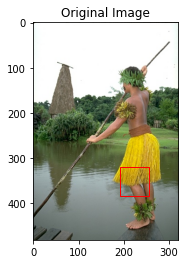

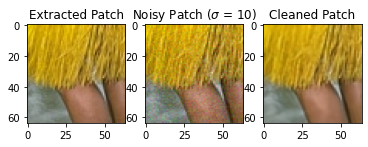

In [ ]:
f1, axarr1 = plt.subplots(1,1)
f, axarr = plt.subplots(1,3)
i = 63
(img_num, p, q) = Patch_position[i]
img = cv2.imread(test_file_list[img_num])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rect = patches.Rectangle((q, p), 64, 64, edgecolor ='r', facecolor = 'none')

axarr1.imshow(img)
axarr1.add_patch(rect)
axarr1.title.set_text('Original Image')

axarr[0].imshow(Patch[i])
axarr[0].title.set_text('Extracted Patch')
axarr[1].imshow(Noisy_patch10[i])
axarr[1].title.set_text('Noisy Patch ($\sigma$ = 10)')
axarr[2].imshow(pred10[i])
axarr[2].title.set_text('Cleaned Patch')
print("PSNR: %s" % psnr10[i])
print("SSIM: %s" % ssim10[i])

### For Noise level: $\sigma$ = 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 29.574257
SSIM: 0.9115788247442689


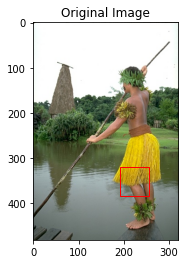

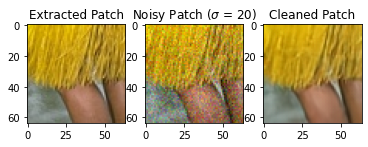

In [ ]:
f1, axarr1 = plt.subplots(1,1)
f, axarr = plt.subplots(1,3)
i = 63
(img_num, p, q) = Patch_position[i]
img = cv2.imread(test_file_list[img_num])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rect = patches.Rectangle((q, p), 64, 64, edgecolor ='r', facecolor = 'none')

axarr1.imshow(img)
axarr1.add_patch(rect)
axarr1.title.set_text('Original Image')

axarr[0].imshow(Patch[i])
axarr[0].title.set_text('Extracted Patch')
axarr[1].imshow(Noisy_patch20[i])
axarr[1].title.set_text('Noisy Patch ($\sigma$ = 20)')
axarr[2].imshow(pred20[i])
axarr[2].title.set_text('Cleaned Patch')
print("PSNR: %s" % psnr20[i])
print("SSIM: %s" % ssim20[i])

### For Noise level: $\sigma$ = 30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 27.711979
SSIM: 0.8632693255588032


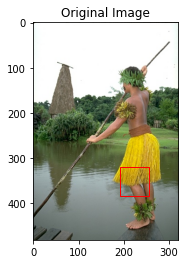

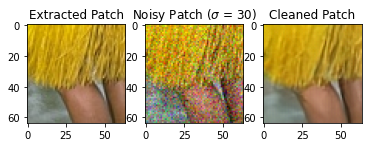

In [ ]:
f1, axarr1 = plt.subplots(1,1)
f, axarr = plt.subplots(1,3)
i = 63
(img_num, p, q) = Patch_position[i]
img = cv2.imread(test_file_list[img_num])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rect = patches.Rectangle((q, p), 64, 64, edgecolor ='r', facecolor = 'none')

axarr1.imshow(img)
axarr1.add_patch(rect)
axarr1.title.set_text('Original Image')

axarr[0].imshow(Patch[i])
axarr[0].title.set_text('Extracted Patch')
axarr[1].imshow(Noisy_patch30[i])
axarr[1].title.set_text('Noisy Patch ($\sigma$ = 30)')
axarr[2].imshow(pred30[i])
axarr[2].title.set_text('Cleaned Patch')
print("PSNR: %s" % psnr30[i])
print("SSIM: %s" % ssim30[i])

### For Noise level: $\sigma$ = 40

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 26.294857
SSIM: 0.8088802857727395


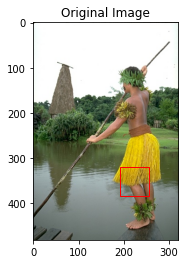

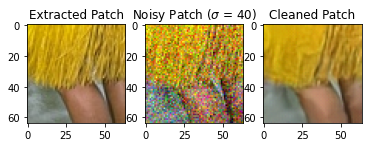

In [ ]:
f1, axarr1 = plt.subplots(1,1)
f, axarr = plt.subplots(1,3)
i = 63
(img_num, p, q) = Patch_position[i]
img = cv2.imread(test_file_list[img_num])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rect = patches.Rectangle((q, p), 64, 64, edgecolor ='r', facecolor = 'none')

axarr1.imshow(img)
axarr1.add_patch(rect)
axarr1.title.set_text('Original Image')

axarr[0].imshow(Patch[i])
axarr[0].title.set_text('Extracted Patch')
axarr[1].imshow(Noisy_patch40[i])
axarr[1].title.set_text('Noisy Patch ($\sigma$ = 40)')
axarr[2].imshow(pred40[i])
axarr[2].title.set_text('Cleaned Patch')
print("PSNR: %s" % psnr40[i])
print("SSIM: %s" % ssim40[i])

### For Noise level: $\sigma$ = 50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 25.274895
SSIM: 0.7642112298782656


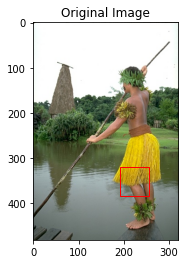

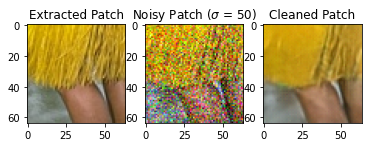

In [ ]:
f1, axarr1 = plt.subplots(1,1)
f, axarr = plt.subplots(1,3)
i = 63
(img_num, p, q) = Patch_position[i]
img = cv2.imread(test_file_list[img_num])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rect = patches.Rectangle((q, p), 64, 64, edgecolor ='r', facecolor = 'none')

axarr1.imshow(img)
axarr1.add_patch(rect)
axarr1.title.set_text('Original Image')

axarr[0].imshow(Patch[i])
axarr[0].title.set_text('Extracted Patch')
axarr[1].imshow(Noisy_patch50[i])
axarr[1].title.set_text('Noisy Patch ($\sigma$ = 50)')
axarr[2].imshow(pred50[i])
axarr[2].title.set_text('Cleaned Patch')
print("PSNR: %s" % psnr50[i])
print("SSIM: %s" % ssim50[i])